# Pi on simons panel autosomes

In [ ]:
import IPython.core.display
# This line will hide code by default when the notebook is exported as HTML
IPython.core.display.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
## This line will add a button to toggle visibility of code blocks, for use with the HTML export version
#IPython.core.display.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)import numpy as np

In [3]:
%matplotlib notebook
from pylab import *
import numpy as np
import pandas as pd
#import matplotlib
#import matplotlib.pyplot as plt

In [22]:
seq = 'ABC'
iterables = [['X'], range(len(seq))]
idx = pd.MultiIndex.from_product(iterables, names=['chrom', 'pos'])
pd.DataFrame({'kasper': np.array(list(seq))}, index=idx)

df = pd.DataFrame({'chrom': 'x', 'pos': range(len(seq)), 'base': np.array(list(seq))})
df.set_index(['chrom', 'pos'], inplace=True)
df['base'].loc['x', 1]
#df.to_hdf('store_tl.h5','table',append=True)



'B'

In [12]:
print Out[10]

KeyError: 10

In [6]:
del _2
del Out[2]
import gc
gc.collect()

NameError: name '_2' is not defined

In [ ]:
#from Bio import SeqIO
import subprocess

def load_individual(indiv):
    p = subprocess.Popen(['zcat', 
                          '/Volumes/GenomeDK/simons/faststorage/cteam_lite_public3/FullyPublic/{}.ccomp.fa.rz'.format(indiv)], 
                         stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = p.communicate()
    frames = list()
    for s in stdout.split('>')[1:]:        
        header, seq = s.split('\n', 1)
        chrom = header.split()[0]
        seq = seq.replace('\n', '')
        iterables = [[chrom], range(len(seq))] # chrom is a encoded as string
        idx = pd.MultiIndex.from_product(iterables, names=['chrom', 'pos'])
        frames.append(pd.DataFrame({indiv: np.array(list(seq))}, index=idx))
    return pd.concat(frames)
        
df = load_individual('S_Abkhasian-1') ;



In [162]:
# tbl_df(read.table('../gdk/pi.tsv', 
#                      col.names = c('chrom', 'start', 'end', 'group', 'indiv1', 'indiv2', 'sex1', 'sex2', 'diff', 'same'))) %>%
#   mutate(indiv1 = gsub('-', '_', indiv1),
#          indiv2 = gsub('-', '_', indiv2),
#          pop = gsub('^[^_]*_', '', group),
#          pi_pair = diff / (diff + same)) %>%
#   mutate(pi_pair=replace(pi_pair, diff + same < 20000, NA)) %>% # filter off windows with less than 20000 called
#   select(chrom, start, end, pop, pi_pair) %>%
#   group_by(chrom, start, end, pop) %>%
#   summarize(PI = mean(pi_pair, na.rm=TRUE)) %>%
#   ungroup() %>%
#   mutate(chrom=factor(chrom, levels=c(1:22, 'X'))) %>%
#   spread(pop, PI) -> pi_data

df = (pd.read_table('./gdk/pi.tsv', 
                   header=None, 
                   names=['chrom', 'start', 'end', 'group', 
                          'indiv1', 'indiv2', 'sex1', 'sex2', 
                          'dif', 'same'])
    .assign(indiv1 = lambda x: [y.replace('-', '') for y in x.indiv1],
            indiv2 = lambda x: [y.replace('-', '') for y in x.indiv2],
            pop = lambda x: [re.sub(r'^[^_]*_', '', y) for y in x.group],
            pi_pair = lambda x: x.dif / (x.dif + x.same))
)




In [151]:
print df.head()

  chrom   start     end    group    indiv1    indiv2 sex1 sex2  dif   same  \
0     1       0  100000  S_Tujia  S_Tujia2  S_Tujia1    F    M   64  56306   
1     1  100000  200000  S_Tujia  S_Tujia2  S_Tujia1    F    M   41  43576   
2     1  200000  300000  S_Tujia  S_Tujia2  S_Tujia1    F    M   28  34365   
3     1  300000  400000  S_Tujia  S_Tujia2  S_Tujia1    F    M    3   2696   
4     1  400000  500000  S_Tujia  S_Tujia2  S_Tujia1    F    M    6    774   

    pi_pair    pop  
0  0.001135  Tujia  
1  0.000940  Tujia  
2  0.000814  Tujia  
3       NaN  Tujia  
4       NaN  Tujia  


In [197]:
df['pi_pair'] = df['pi_pair'].where(df['dif'] + df['same'] >= 20000)

suma = (df[['chrom', 'start', 'end', 'pop', 'pi_pair']]
    .groupby(['chrom', 'start', 'end', 'pop'])
    .aggregate(np.mean)
    .reset_index()
)

print suma.head()

  chrom  start     end        pop   pi_pair
0     1      0  100000  Abkhasian       NaN
1     1      0  100000     Adygei       NaN
2     1      0  100000      Aleut  0.002726
3     1      0  100000        Ami  0.001026
4     1      0  100000   Armenian  0.000972


In [222]:
wide = pd.pivot_table(suma, index=["chrom","start", "end"], 
                      columns=['pop'], values=['pi_pair'])

In [223]:
print wide['pi_pair']['Abkhasian'].loc['X', 0:300000, 0:300000]

chrom  start   end   
X      0       100000    0.002059
       100000  200000    0.003962
       200000  300000    0.003190
Name: Abkhasian, dtype: float64


In [266]:
def quantile_normalization(df):
    A=df.as_matrix()
    AA = np.zeros_like(A)
    I = np.argsort(A,axis=0)
    AA[I,np.arange(A.shape[1])] = np.mean(A[I,np.arange(A.shape[1])],axis=1)[:,np.newaxis]
    return pd.DataFrame(AA, columns=df.columns, index=df.index)

# make sure we only do this on complete cases:
wide[wide.isnull().any(axis=1)] = np.nan
# otherwise nans will crate a bias. If there are nore nans in one col 
# them that means that that all the highest values are removed from the other columns

qqnorm = quantile_normalization(wide)



In [ ]:
#qqnorm['pi_pair'].loc['22'].plot(kind='line')
high = qqnorm.stack()
#print high.columns
#print high['pi_pair'].loc['1', 100000, 200000, 'Abkhasian']
#print high['pi_pair'].head()

In [312]:
dff = high['pi_pair'].reset_index()[['pop', 'pi_pair']]
#print dff
print dff.groupby('pop').agg([np.mean, np.std, np.min, np.max])


#print dff

#.groupby('pop')

                pi_pair                              
                   mean       std      amin      amax
pop                                                  
Abkhasian      0.000913  0.000651  0.000004  0.037259
Adygei         0.000913  0.000651  0.000004  0.037259
Aleut          0.000913  0.000651  0.000004  0.037259
Ami            0.000913  0.000651  0.000004  0.037259
Armenian       0.000913  0.000651  0.000004  0.037259
Australian     0.000913  0.000651  0.000004  0.037259
Balochi        0.000913  0.000651  0.000004  0.037259
BantuHerero    0.000913  0.000651  0.000004  0.037259
BantuKenya     0.000913  0.000651  0.000004  0.037259
BantuTswana    0.000913  0.000651  0.000004  0.037259
Basque         0.000913  0.000651  0.000004  0.037259
BedouinB       0.000913  0.000651  0.000004  0.037259
Bengali        0.000913  0.000651  0.000004  0.037259
Bergamo        0.000913  0.000651  0.000004  0.037259
Biaka          0.000913  0.000651  0.000004  0.037259
Bougainville   0.000913  0.0

## Generate data:

In [41]:


import numpy as np

np.random.seed(7) # random seed for consistency

# A reader pointed out that Python 2.7 would raise a
# "ValueError: object of too small depth for desired array".
# This can be avoided by choosing a smaller random seed, e.g. 1
# or by completely omitting this line, since I just used the random seed for
# consistency.

mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20).T
assert class1_sample.shape == (3,20), "The matrix has not the dimensions 3x20"

mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20).T
assert class1_sample.shape == (3,20), "The matrix has not the dimensions 3x20"

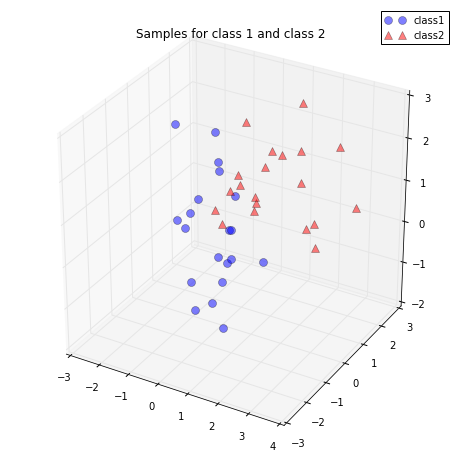

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='class1')
ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:], '^', markersize=8, alpha=0.5, color='red', label='class2')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')

plt.show()

In [4]:
all_samples = np.concatenate((class1_sample, class2_sample), axis=1)
assert all_samples.shape == (3,40), "The matrix has not the dimensions 3x40"

## Compute means

In [ ]:


mean_x = np.mean(all_samples[0,:])
mean_y = np.mean(all_samples[1,:])
mean_z = np.mean(all_samples[2,:])

mean_vector = np.array([[mean_x],[mean_y],[mean_z]])

print("Mean vector")
print(mean_vector)

## Compute scatter matrix or cov matrix

In [ ]:
scatter_matrix = np.zeros((3,3))
for i in range(all_samples.shape[1]):
    scatter_matrix += (all_samples[:,i].reshape(3,1) - mean_vector).dot((all_samples[:,i].reshape(3,1) - mean_vector).T)
print('Scatter Matrix')
print(scatter_matrix)

In [13]:
cov_mat = np.cov([all_samples[0,:],all_samples[1,:],all_samples[2,:]])
print('Covariance Matrix')
print(cov_mat)

Covariance Matrix
[[ 1.33604162  0.21546098  0.1358902 ]
 [ 0.21546098  1.47863453  0.32668112]
 [ 0.1358902   0.32668112  1.16718576]]


## Compute eigenvectors and eigenvalues

In [14]:
# eigenvectors and eigenvalues for the from the scatter matrix
eig_val_sc, eig_vec_sc = np.linalg.eig(scatter_matrix)

# eigenvectors and eigenvalues for the from the covariance matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)

for i in range(len(eig_val_sc)):
    eigvec_sc = eig_vec_sc[:,i].reshape(1,3).T
    eigvec_cov = eig_vec_cov[:,i].reshape(1,3).T
    assert eigvec_sc.all() == eigvec_cov.all(), 'Eigenvectors are not identical'

    print('Eigenvector {}: \n{}'.format(i+1, eigvec_sc))
    print('Eigenvalue {} from scatter matrix: {}'.format(i+1, eig_val_sc[i]))
    print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i]))
    print('Scaling factor: ', eig_val_sc[i]/eig_val_cov[i])
    print(40 * '-')

Eigenvector 1: 
[[-0.46642995]
 [-0.74806213]
 [-0.47206583]]
Eigenvalue 1 from scatter matrix: 70.9461057887
Eigenvalue 1 from covariance matrix: 1.81913091766
('Scaling factor: ', 38.999999999999964)
----------------------------------------
Eigenvector 2: 
[[-0.8845581 ]
 [ 0.3942924 ]
 [ 0.24917961]]
Eigenvalue 2 from scatter matrix: 46.8670615139
Eigenvalue 2 from covariance matrix: 1.201719526
('Scaling factor: ', 38.999999999999986)
----------------------------------------
Eigenvector 3: 
[[  2.69854259e-04]
 [ -5.33794488e-01]
 [  8.45614198e-01]]
Eigenvalue 3 from scatter matrix: 37.4794470767
Eigenvalue 3 from covariance matrix: 0.961011463505
('Scaling factor: ', 38.999999999999979)
----------------------------------------


In [15]:
for i in range(len(eig_val_sc)):
    eigv = eig_vec_sc[:,i].reshape(1,3).T
    np.testing.assert_array_almost_equal(scatter_matrix.dot(eigv), eig_val_sc[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)

<IPython.core.display.Javascript object>


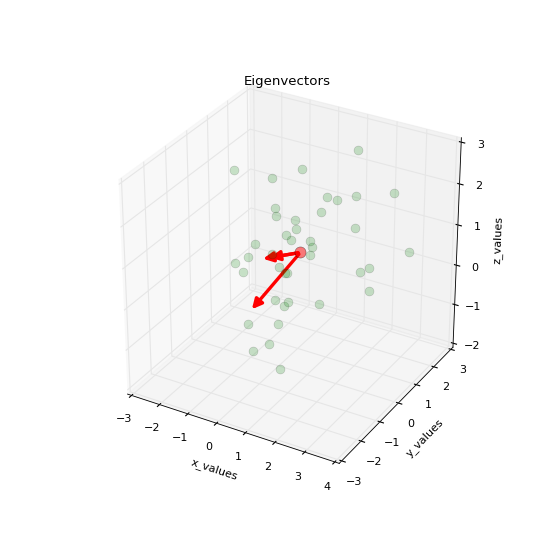

In [34]:
%matplotlib notebook

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec_sc.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

## Sorting the eigenvectors by decreasing eigenvalues

In [36]:
for ev in eig_vec_sc:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
    # instead of 'assert' because of rounding errors

In [37]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_sc[i]), eig_vec_sc[:,i]) for i in range(len(eig_val_sc))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs:
    print(i[0])

70.9461057887
46.8670615139
37.4794470767


## Choosing k eigenvectors with the largest eigenvalues

In [54]:
#print np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1)))

print eig_pairs[0][1])

#print [vec.reshape(len(vec), 1) for val, vec in eig_pairs]
print [vec.reshape(3, 1) for val, vec in eig_pairs]



matrix_w = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1)))
print('Matrix W:\n{}'.format(matrix_w))

AttributeError: 'numpy.ndarray' object has no attribute 'length'

## Transforming the samples onto the new subspace

In [42]:
transformed = matrix_w.T.dot(all_samples)
assert transformed.shape == (2,40), "The matrix is not 2x40 dimensional."

[[-0.46642995 -0.8845581 ]
 [-0.74806213  0.3942924 ]
 [-0.47206583  0.24917961]]


<IPython.core.display.Javascript object>


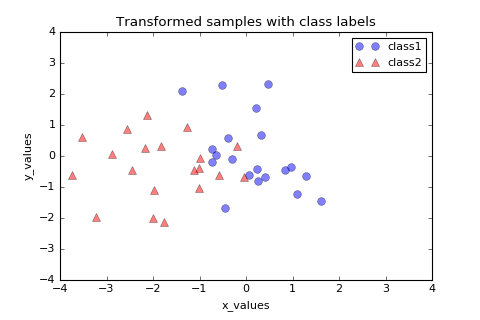

In [40]:
plt.figure()
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.show()